In [14]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from matplotlib import pyplot as plt

from lib.generate_data import Sampler, DummyData, MultitaskSparseParity
from lib.tracking import AnalyticsManager

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up data

In [15]:
n_data_bits = 100
# n_control_bits = 500
n_control_bits = 5
k = 3
alpha = 0.4

sampler: Sampler = MultitaskSparseParity(n_control_bits, n_data_bits, k=k, alpha=alpha)
# sampler: Sampler = DummyData(n_control_bits + n_data_bits)

In [16]:
sampler.generate_data(2)

/home/rmkj/Documents/Research/quantization-neural-scaling/lib/generate_data.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


(tensor([[1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
          1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
          1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
          1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
          1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
          1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
          1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
          0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
          1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
          0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1.]],
        dtype=torch.float64),
 tensor

In [17]:

%timeit sampler.generate_data(20000)

143 ms ± 53.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Train Network

In [18]:
batch_size = 20000
training_size = 1e5

n_hidden = 200
lr = 1e-3
n_epochs = 100
optimizer_func = lambda model: torch.optim.Adam(model.parameters(), lr=lr)
loss_func = torch.nn.BCELoss()

In [19]:
class TinyModel(torch.nn.Module):

    def __init__(self, n_hidden: int):
        super(TinyModel, self).__init__()

        self.linear1 = torch.nn.Linear(n_control_bits + n_data_bits, n_hidden)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(n_hidden, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

model = TinyModel(n_hidden)
optimizer = optimizer_func(model)

In [20]:
# %matplotlib notebook
# from time import sleep

# fig = plt.figure()
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212, sharex=ax1)

# for i in range(30):
#     ax1.plot(range(i))
#     plt.show()
#     sleep(1)

In [21]:
def calculate_loss(X, y, model):
    y_pred = model(X.float())
    loss = loss_func(y_pred, y[:, None].float())
    return loss


In [22]:
loss_history = []
logger = AnalyticsManager()

for epoch in range(n_epochs):
    for i in range(int(training_size // batch_size)):
        X_batch, y_batch = sampler.generate_data(batch_size)

        loss = calculate_loss(X_batch, y_batch, model)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


        logger.log({"loss": loss.item()})
        
    print(f"Epoch: {epoch} loss: {loss.item()}")

Epoch: 0 loss: 0.6952510476112366
Epoch: 1 loss: 0.6940045356750488
Epoch: 2 loss: 0.6932764649391174
Epoch: 3 loss: 0.6932312846183777
Epoch: 4 loss: 0.6935055255889893
Epoch: 5 loss: 0.6934376358985901
Epoch: 6 loss: 0.6935672163963318
Epoch: 7 loss: 0.6932134628295898
Epoch: 8 loss: 0.6932582259178162
Epoch: 9 loss: 0.6934680342674255
Epoch: 10 loss: 0.6934494376182556
Epoch: 11 loss: 0.693199098110199
Epoch: 12 loss: 0.693295419216156
Epoch: 13 loss: 0.6932206153869629
Epoch: 14 loss: 0.6933576464653015
Epoch: 15 loss: 0.6933081150054932
Epoch: 16 loss: 0.6933667063713074
Epoch: 17 loss: 0.6932554244995117
Epoch: 18 loss: 0.6930332183837891
Epoch: 19 loss: 0.6931421160697937
Epoch: 20 loss: 0.6931079030036926
Epoch: 21 loss: 0.6929863095283508
Epoch: 22 loss: 0.6928369998931885
Epoch: 23 loss: 0.6927570104598999
Epoch: 24 loss: 0.6928592920303345
Epoch: 25 loss: 0.6922284960746765
Epoch: 26 loss: 0.6920102834701538
Epoch: 27 loss: 0.6913576126098633
Epoch: 28 loss: 0.69076472520828

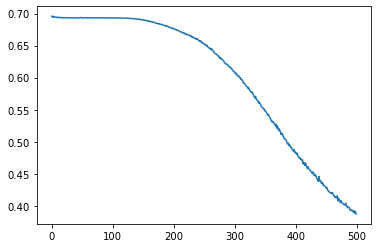

In [23]:
plt.plot(logger.metrics["loss"])